In [1]:
# This mounts your Google Drive to the Colab VM.
# from google.colab import drive
# drive.mount('/content/drive')

# TODO: Enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment1/'
FOLDERNAME = '/home/roark/Documents/coursesDL/cs231n_2023/cs231nsp23HW/assignment1'

assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
# sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))
sys.path.append(FOLDERNAME)

# This downloads the CIFAR-10 dataset to your Drive
# if it doesn't already exist.
# %cd /content/drive/My\ Drive/$FOLDERNAME/cs231n/datasets/
# !bash get_datasets.sh
# %cd /content/drive/My\ Drive/$FOLDERNAME
%cd $FOLDERNAME/cs231n/datasets/
!bash get_datasets.sh
%cd $FOLDERNAME

/home/roark/Documents/coursesDL/cs231n_2023/cs231nsp23HW/assignment1/cs231n/datasets
/home/roark/Documents/coursesDL/cs231n_2023/cs231nsp23HW/assignment1


# Softmax exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

This exercise is analogous to the SVM exercise. You will:

- implement a fully-vectorized **loss function** for the Softmax classifier
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** with numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [2]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (8.0, 6.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [3]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'
    
    # Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
    try:
       del X_train, y_train
       del X_test, y_test
       print('Clear previously loaded data.')
    except:
       pass

    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Softmax Classifier

Your code for this section will all be written inside `cs231n/classifiers/softmax.py`.


In [4]:
# First implement the naive softmax loss function with nested loops.
# Open the file cs231n/classifiers/softmax.py and implement the
# softmax_loss_naive function.

from cs231n.classifiers.softmax import softmax_loss_naive
import time

# Generate a random softmax weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.382442
sanity check: 2.302585


**Inline Question 1**

Why do we expect our loss to be close to -log(0.1)? Explain briefly.**

$\color{blue}{\textit Your Answer:}$
$$Loss = -\frac{1}{N}∑_{i=1}^Nlog\frac{e^{S_{yi}}}{∑_je^S_j}$$
当w初始化为均值为0的极小值时，scores也大约为0附件的很小的值，因此$$e^{s_j}≈1$$
$$-\frac{1}{N}∑_{i=1}^Nlog\frac{e^{S_{yi}}}{∑_je^S_j}≈-\frac{1}{N}*N*log\frac{1}{C}≈-log\frac{1}{10}$$


In [5]:
# Complete the implementation of softmax_loss_naive and implement a (naive)
# version of the gradient that uses nested loops.
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 0.0)

# As we did for the SVM, use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

# similar to SVM case, do another gradient check with regularization
loss, grad = softmax_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: softmax_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad, 10)

numerical: 4.476615 analytic: 4.476615, relative error: 3.310948e-08
numerical: 0.356372 analytic: 0.356372, relative error: 1.119414e-07
numerical: -0.755814 analytic: -0.755814, relative error: 2.471785e-08
numerical: 0.308663 analytic: 0.308663, relative error: 3.476294e-07
numerical: 4.691961 analytic: 4.691961, relative error: 3.167460e-08
numerical: -0.232183 analytic: -0.232183, relative error: 9.987430e-08
numerical: -0.361611 analytic: -0.361611, relative error: 3.067619e-08
numerical: 2.376714 analytic: 2.376714, relative error: 5.254403e-10
numerical: 0.996779 analytic: 0.996778, relative error: 1.205909e-07
numerical: 2.796696 analytic: 2.796696, relative error: 3.296308e-08
numerical: -0.073047 analytic: -0.073047, relative error: 6.829955e-09
numerical: 0.279318 analytic: 0.279318, relative error: 9.759090e-08
numerical: 5.603353 analytic: 5.603352, relative error: 2.076887e-08
numerical: 2.879929 analytic: 2.879929, relative error: 1.372671e-08
numerical: -0.383268 analy

In [11]:
# Now that we have a naive implementation of the softmax loss function and its gradient,
# implement a vectorized version in softmax_loss_vectorized.
# The two versions should compute the same results, but the vectorized version should be
# much faster.
tic = time.time()
loss_naive, grad_naive = softmax_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.softmax import softmax_loss_vectorized
tic = time.time()
loss_vectorized, grad_vectorized = softmax_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# As we did for the SVM, we use the Frobenius norm to compare the two versions
# of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

naive loss: 2.382442e+00 computed in 0.110460s
vectorized loss: 2.382442e+00 computed in 0.001796s
Loss difference: 0.000000
Gradient difference: 0.000000


In [12]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of over 0.35 on the validation set.

from cs231n.classifiers import Softmax
results = {}
best_val = -1
best_softmax = None

################################################################################
# TODO:                                                                        #
# Use the validation set to set the learning rate and regularization strength. #
# This should be identical to the validation that you did for the SVM; save    #
# the best trained softmax classifer in best_softmax.                          #
################################################################################

# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
##################################
# rk's remark:                   #
#          random search         #
##################################

# sample learning_rates
exp_lr = -10 * np.random.rand(10)
learning_rates = np.power(10, exp_lr)

# sample regs
exp_reg = 7 * np.random.rand(10)
reg_strengths = np.power(10, exp_reg)
para_group = [(np.random.choice(learning_rates, replace=False), 
               np.random.choice(reg_strengths, replace=False)) for _ in range(20)]

###  comment out after try out coarse grid
# for lr, reg in para_group:
#     softmax = Softmax()
#     loss_history = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
#                                  num_iters=2000, verbose=True)
#     y_train_pred = softmax.predict(X_train)
#     train_acc = np.sum((y_train_pred == y_train)) / y_train.shape[0]
#     y_val_pred = softmax.predict(X_val)
#     val_acc = np.sum((y_val_pred == y_val)) / y_val.shape[0]
#     if(val_acc > best_val):
#         best_val=val_acc
#         best_softmax=softmax
#     results[(lr,reg)]=(train_acc,val_acc)
###  best result from coarse grid: 
###  => best validation accuracy achieved during cross-validation: 0.416000

### refine grid
lr_fine = [3e-7, 2e-6]
reg_fine = [1e1, 2e3]

for lr in np.linspace(lr_fine[0], lr_fine[1], 10):
    for reg in np.linspace(reg_fine[0], reg_fine[1], 10):
        softmax = Softmax()
        loss_history = softmax.train(X_train, y_train, learning_rate=lr, reg=reg,
                                     num_iters=2000, verbose=True)
        y_train_pred = softmax.predict(X_train)
        train_acc = np.sum((y_train_pred == y_train)) / y_train.shape[0]
        y_val_pred = softmax.predict(X_val)
        val_acc = np.sum((y_val_pred == y_val)) / y_val.shape[0]
        if(val_acc > best_val):
            best_val=val_acc
            best_softmax=softmax
        results[(lr,reg)]=(train_acc,val_acc)
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

iteration 0 / 2000: loss 6.006476
iteration 100 / 2000: loss 3.367348
iteration 200 / 2000: loss 2.987008
iteration 300 / 2000: loss 2.985845
iteration 400 / 2000: loss 3.017161
iteration 500 / 2000: loss 2.951382
iteration 600 / 2000: loss 2.885876
iteration 700 / 2000: loss 2.736034
iteration 800 / 2000: loss 2.528246
iteration 900 / 2000: loss 2.507417
iteration 1000 / 2000: loss 2.728991
iteration 1100 / 2000: loss 2.579596
iteration 1200 / 2000: loss 2.589637
iteration 1300 / 2000: loss 2.543153
iteration 1400 / 2000: loss 2.513352
iteration 1500 / 2000: loss 2.443709
iteration 1600 / 2000: loss 2.420289
iteration 1700 / 2000: loss 2.608852
iteration 1800 / 2000: loss 2.581663
iteration 1900 / 2000: loss 2.342864
iteration 0 / 2000: loss 13.537786
iteration 100 / 2000: loss 10.159590
iteration 200 / 2000: loss 9.540649
iteration 300 / 2000: loss 9.352724
iteration 400 / 2000: loss 8.781295
iteration 500 / 2000: loss 8.229303
iteration 600 / 2000: loss 8.247981
iteration 700 / 2000

iteration 300 / 2000: loss 8.549719
iteration 400 / 2000: loss 8.179948
iteration 500 / 2000: loss 8.021295
iteration 600 / 2000: loss 7.419436
iteration 700 / 2000: loss 7.160181
iteration 800 / 2000: loss 6.958036
iteration 900 / 2000: loss 6.450384
iteration 1000 / 2000: loss 6.384537
iteration 1100 / 2000: loss 6.091222
iteration 1200 / 2000: loss 5.861746
iteration 1300 / 2000: loss 5.793336
iteration 1400 / 2000: loss 5.606516
iteration 1500 / 2000: loss 5.404273
iteration 1600 / 2000: loss 5.057147
iteration 1700 / 2000: loss 4.893401
iteration 1800 / 2000: loss 4.958209
iteration 1900 / 2000: loss 4.700588
iteration 0 / 2000: loss 19.541647
iteration 100 / 2000: loss 15.677672
iteration 200 / 2000: loss 14.360120
iteration 300 / 2000: loss 12.816803
iteration 400 / 2000: loss 11.923259
iteration 500 / 2000: loss 10.903041
iteration 600 / 2000: loss 10.010185
iteration 700 / 2000: loss 9.454154
iteration 800 / 2000: loss 8.672840
iteration 900 / 2000: loss 8.057209
iteration 100

iteration 700 / 2000: loss 7.587212
iteration 800 / 2000: loss 6.866475
iteration 900 / 2000: loss 6.327231
iteration 1000 / 2000: loss 5.693651
iteration 1100 / 2000: loss 5.242213
iteration 1200 / 2000: loss 4.954659
iteration 1300 / 2000: loss 4.535040
iteration 1400 / 2000: loss 4.153812
iteration 1500 / 2000: loss 3.956360
iteration 1600 / 2000: loss 3.567173
iteration 1700 / 2000: loss 3.491076
iteration 1800 / 2000: loss 3.314182
iteration 1900 / 2000: loss 3.007162
iteration 0 / 2000: loss 25.900796
iteration 100 / 2000: loss 19.719248
iteration 200 / 2000: loss 16.356507
iteration 300 / 2000: loss 13.776464
iteration 400 / 2000: loss 11.819668
iteration 500 / 2000: loss 9.906270
iteration 600 / 2000: loss 8.549046
iteration 700 / 2000: loss 7.337500
iteration 800 / 2000: loss 6.333432
iteration 900 / 2000: loss 5.699619
iteration 1000 / 2000: loss 4.973514
iteration 1100 / 2000: loss 4.303744
iteration 1200 / 2000: loss 4.116774
iteration 1300 / 2000: loss 3.703035
iteration 1

iteration 1100 / 2000: loss 3.293889
iteration 1200 / 2000: loss 2.965926
iteration 1300 / 2000: loss 2.629193
iteration 1400 / 2000: loss 2.513704
iteration 1500 / 2000: loss 2.388926
iteration 1600 / 2000: loss 2.281188
iteration 1700 / 2000: loss 2.167973
iteration 1800 / 2000: loss 1.966818
iteration 1900 / 2000: loss 2.101010
iteration 0 / 2000: loss 33.753078
iteration 100 / 2000: loss 22.652186
iteration 200 / 2000: loss 16.735123
iteration 300 / 2000: loss 12.488645
iteration 400 / 2000: loss 9.743467
iteration 500 / 2000: loss 7.594869
iteration 600 / 2000: loss 5.920269
iteration 700 / 2000: loss 4.753866
iteration 800 / 2000: loss 3.957601
iteration 900 / 2000: loss 3.330851
iteration 1000 / 2000: loss 3.025875
iteration 1100 / 2000: loss 2.617520
iteration 1200 / 2000: loss 2.410278
iteration 1300 / 2000: loss 2.249566
iteration 1400 / 2000: loss 2.238070
iteration 1500 / 2000: loss 2.106134
iteration 1600 / 2000: loss 1.992516
iteration 1700 / 2000: loss 1.998925
iteration

iteration 1600 / 2000: loss 1.951807
iteration 1700 / 2000: loss 1.768931
iteration 1800 / 2000: loss 1.838175
iteration 1900 / 2000: loss 1.893974
iteration 0 / 2000: loss 40.346409
iteration 100 / 2000: loss 23.590170
iteration 200 / 2000: loss 15.076320
iteration 300 / 2000: loss 9.922978
iteration 400 / 2000: loss 6.854413
iteration 500 / 2000: loss 4.972800
iteration 600 / 2000: loss 3.757084
iteration 700 / 2000: loss 3.127582
iteration 800 / 2000: loss 2.503225
iteration 900 / 2000: loss 2.321769
iteration 1000 / 2000: loss 2.248616
iteration 1100 / 2000: loss 2.006110
iteration 1200 / 2000: loss 1.871207
iteration 1300 / 2000: loss 1.933123
iteration 1400 / 2000: loss 1.785304
iteration 1500 / 2000: loss 1.897424
iteration 1600 / 2000: loss 1.872429
iteration 1700 / 2000: loss 1.774050
iteration 1800 / 2000: loss 1.907730
iteration 1900 / 2000: loss 1.819064
iteration 0 / 2000: loss 47.001073
iteration 100 / 2000: loss 25.580983
iteration 200 / 2000: loss 15.057293
iteration 30

iteration 100 / 2000: loss 23.122718
iteration 200 / 2000: loss 12.406608
iteration 300 / 2000: loss 7.277041
iteration 400 / 2000: loss 4.638713
iteration 500 / 2000: loss 3.261128
iteration 600 / 2000: loss 2.558892
iteration 700 / 2000: loss 2.248062
iteration 800 / 2000: loss 2.040942
iteration 900 / 2000: loss 1.860940
iteration 1000 / 2000: loss 1.835283
iteration 1100 / 2000: loss 2.004551
iteration 1200 / 2000: loss 1.884924
iteration 1300 / 2000: loss 1.949290
iteration 1400 / 2000: loss 1.923421
iteration 1500 / 2000: loss 1.918333
iteration 1600 / 2000: loss 1.904868
iteration 1700 / 2000: loss 1.817791
iteration 1800 / 2000: loss 1.853321
iteration 1900 / 2000: loss 1.865582
iteration 0 / 2000: loss 53.602579
iteration 100 / 2000: loss 23.874510
iteration 200 / 2000: loss 11.705686
iteration 300 / 2000: loss 6.487625
iteration 400 / 2000: loss 3.928393
iteration 500 / 2000: loss 2.790433
iteration 600 / 2000: loss 2.209374
iteration 700 / 2000: loss 2.035993
iteration 800 /

iteration 600 / 2000: loss 2.133844
iteration 700 / 2000: loss 1.904525
iteration 800 / 2000: loss 1.922808
iteration 900 / 2000: loss 1.991188
iteration 1000 / 2000: loss 1.964017
iteration 1100 / 2000: loss 1.880533
iteration 1200 / 2000: loss 1.928202
iteration 1300 / 2000: loss 1.863732
iteration 1400 / 2000: loss 1.886835
iteration 1500 / 2000: loss 1.898641
iteration 1600 / 2000: loss 1.810608
iteration 1700 / 2000: loss 1.882434
iteration 1800 / 2000: loss 1.760422
iteration 1900 / 2000: loss 1.866286
iteration 0 / 2000: loss 60.445817
iteration 100 / 2000: loss 21.502243
iteration 200 / 2000: loss 8.860638
iteration 300 / 2000: loss 4.281476
iteration 400 / 2000: loss 2.840090
iteration 500 / 2000: loss 2.198419
iteration 600 / 2000: loss 2.024519
iteration 700 / 2000: loss 1.914997
iteration 800 / 2000: loss 1.867301
iteration 900 / 2000: loss 1.837238
iteration 1000 / 2000: loss 1.888614
iteration 1100 / 2000: loss 1.875274
iteration 1200 / 2000: loss 1.976519
iteration 1300 

iteration 1100 / 2000: loss 1.942213
iteration 1200 / 2000: loss 1.981144
iteration 1300 / 2000: loss 1.929888
iteration 1400 / 2000: loss 1.996661
iteration 1500 / 2000: loss 1.818336
iteration 1600 / 2000: loss 1.875279
iteration 1700 / 2000: loss 1.792015
iteration 1800 / 2000: loss 1.897810
iteration 1900 / 2000: loss 1.968229
iteration 0 / 2000: loss 67.557968
iteration 100 / 2000: loss 18.596132
iteration 200 / 2000: loss 6.151491
iteration 300 / 2000: loss 3.108074
iteration 400 / 2000: loss 2.163228
iteration 500 / 2000: loss 1.964810
iteration 600 / 2000: loss 1.921514
iteration 700 / 2000: loss 1.845892
iteration 800 / 2000: loss 1.864284
iteration 900 / 2000: loss 1.861819
iteration 1000 / 2000: loss 1.895095
iteration 1100 / 2000: loss 1.917376
iteration 1200 / 2000: loss 1.956814
iteration 1300 / 2000: loss 1.940232
iteration 1400 / 2000: loss 1.880812
iteration 1500 / 2000: loss 1.926278
iteration 1600 / 2000: loss 1.826805
iteration 1700 / 2000: loss 1.851556
iteration 1

iteration 1600 / 2000: loss 1.940068
iteration 1700 / 2000: loss 2.018796
iteration 1800 / 2000: loss 1.852861
iteration 1900 / 2000: loss 1.879451
iteration 0 / 2000: loss 5.704468
iteration 100 / 2000: loss 2.899752
iteration 200 / 2000: loss 2.612920
iteration 300 / 2000: loss 2.440472
iteration 400 / 2000: loss 2.415428
iteration 500 / 2000: loss 2.237491
iteration 600 / 2000: loss 2.228027
iteration 700 / 2000: loss 2.185855
iteration 800 / 2000: loss 2.200766
iteration 900 / 2000: loss 2.027757
iteration 1000 / 2000: loss 2.184540
iteration 1100 / 2000: loss 2.123079
iteration 1200 / 2000: loss 2.232052
iteration 1300 / 2000: loss 2.026025
iteration 1400 / 2000: loss 2.069463
iteration 1500 / 2000: loss 2.203550
iteration 1600 / 2000: loss 1.990263
iteration 1700 / 2000: loss 2.088135
iteration 1800 / 2000: loss 2.106206
iteration 1900 / 2000: loss 1.881854
iteration 0 / 2000: loss 13.824365
iteration 100 / 2000: loss 8.266277
iteration 200 / 2000: loss 6.991428
iteration 300 / 2

In [13]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.395000


**Inline Question 2** - *True or False*

Suppose the overall training loss is defined as the sum of the per-datapoint loss over all training examples. It is possible to add a new datapoint to a training set that would leave the SVM loss unchanged, but this is not the case with the Softmax classifier loss.

$\color{blue}{\textit Your Answer:}$


$\color{blue}{\textit Your Explanation:}$



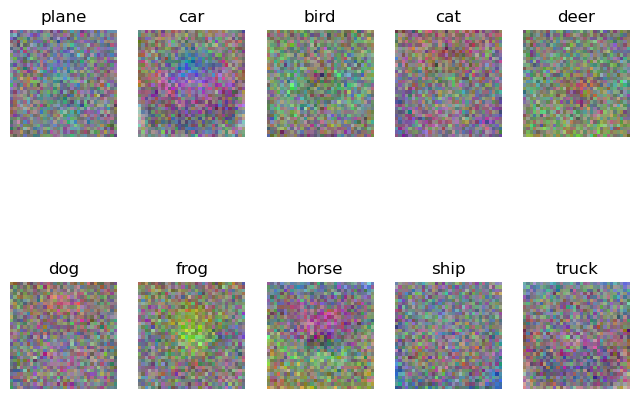

In [14]:
# Visualize the learned weights for each class
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
    
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])